# Assignment 3(due on 11/22)

## Student:朱昱光（12332329），Gtihub：zhu-svg
## 批改人：张鹏


## 得分：59/60

In [1]:
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## 1. Niño 3.4 index

In [4]:
ds=xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

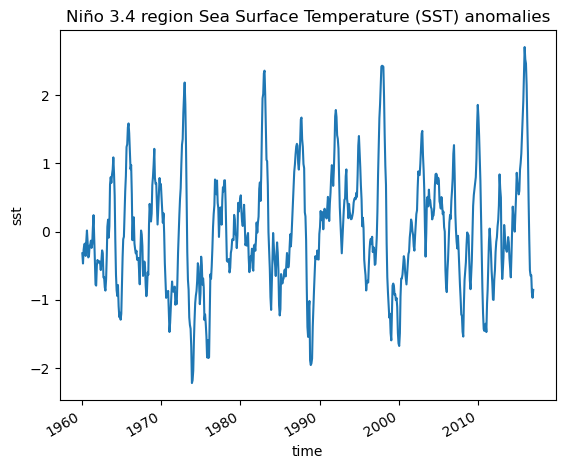

In [6]:
nino34_sst = ds['sst'].sel(lon=slice(-170+360, -120+360), lat=slice(-5, 5))

# 计算该区域的月度气候学
climatology = nino34_sst.groupby('time.month').mean('time')

# 计算异常值
anomalies = nino34_sst.groupby('time.month') - climatology

# 可视化异常值
anomalies.mean(['lon', 'lat']).plot() # 对经纬度取平均，只显示时间序列
plt.title('Niño 3.4 region Sea Surface Temperature (SST) anomalies')
plt.show()

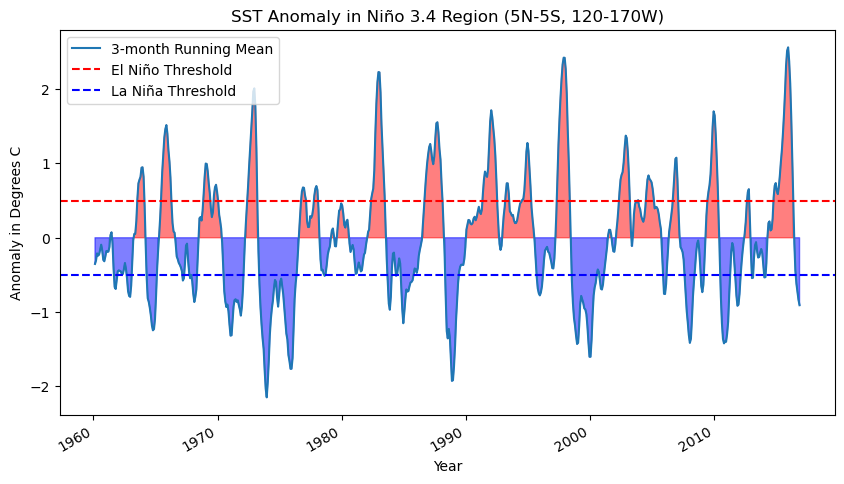

In [7]:
# 应用3个月滑动平均
anomalies_rolling = anomalies.rolling(time=3, center=True).mean()

# 计算异常值的时间平均值
time_avg_anomalies = anomalies_rolling.mean(dim=['lat', 'lon'])

# 绘制图表
plt.figure(figsize=(10, 5))
time_avg_anomalies.plot(label='3-month Running Mean')
plt.axhline(0.5, color='red', linestyle='--', label='El Niño Threshold')
plt.axhline(-0.5, color='blue', linestyle='--', label='La Niña Threshold')
plt.fill_between(time_avg_anomalies.time.values, 0, time_avg_anomalies, where=time_avg_anomalies > 0, color='red', alpha=0.5)
plt.fill_between(time_avg_anomalies.time.values, 0, time_avg_anomalies, where=time_avg_anomalies < 0, color='blue', alpha=0.5)
plt.title('SST Anomaly in Niño 3.4 Region (5N-5S, 120-170W)')
plt.xlabel('Year')
plt.ylabel('Anomaly in Degrees C')
plt.legend()
plt.show()

### 第一题代码运行正常，可以输出正确结果，报告中也展示了输出内容和详细的结果的分析。

### 得分：20/20
### --------------------------------------------------------------------------------------------


## 2. Earth’s energy budget

In [18]:
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [8]:
ds=xr.open_dataset('CERES_EBAF-TOA_200003-201701.nc')


In [9]:
# 计算时间平均值
toa_lw_mean = ds['toa_lw_all_mon'].mean(dim='time')
toa_sw_mean = ds['toa_sw_all_mon'].mean(dim='time')
solar_mean = ds['solar_mon'].mean(dim='time')

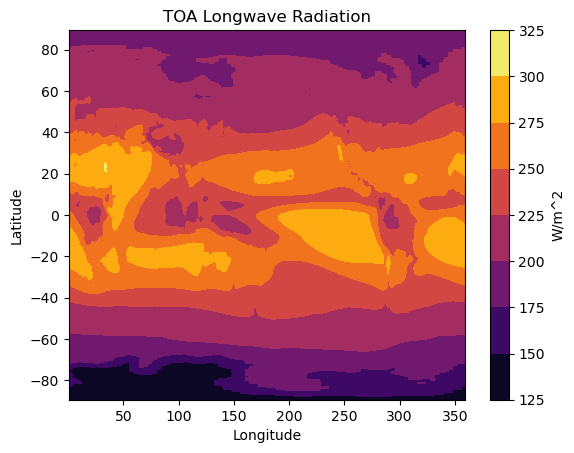

In [10]:
#绘制长波辐射
plt.contourf(toa_lw_mean.lon, toa_lw_mean.lat, toa_lw_mean, cmap='inferno')
plt.title('TOA Longwave Radiation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='W/m^2')
plt.show()

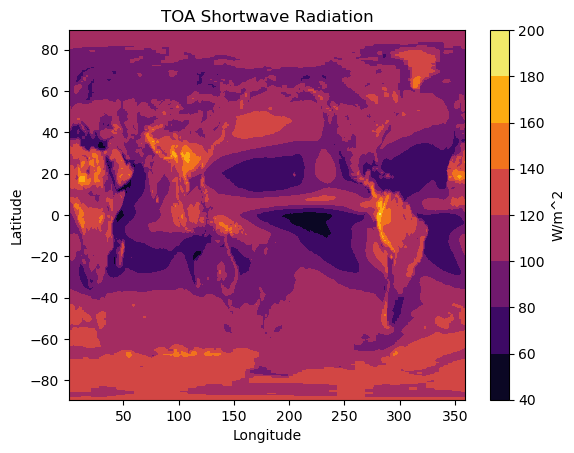

In [11]:
#绘制短波辐射
plt.contourf(toa_sw_mean.lon, toa_sw_mean.lat, toa_sw_mean, cmap='inferno')
plt.title('TOA Shortwave Radiation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='W/m^2')
plt.show()

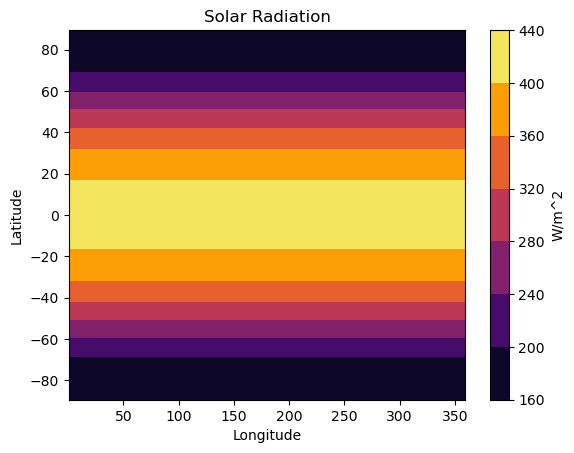

In [12]:
# Plot Solar Radiation
plt.contourf(solar_mean.lon, solar_mean.lat, solar_mean, cmap='inferno')
plt.title('Solar Radiation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='W/m^2')
plt.show()

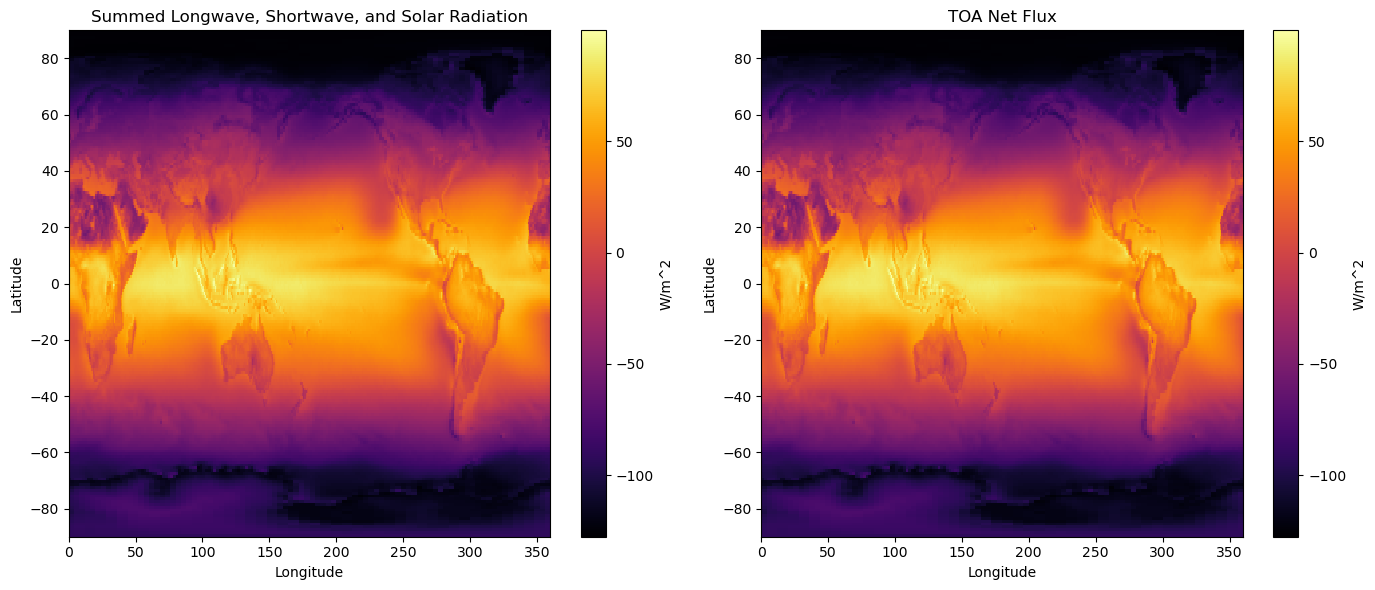

In [13]:
# Create a 2D meshgrid for the lon and lat data
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Sum the TOA longwave, shortwave, and solar radiation to get the total incoming radiation计算辐射量，
total_incoming_mean = solar_mean-toa_lw_mean - toa_sw_mean 

# 根据所给的数据得出辐射量
toa_net_mean = ds['toa_net_all_mon'].mean(dim='time')


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the summed radiation mean
summed_plot = ax1.pcolormesh(lon, lat, total_incoming_mean, cmap='inferno')
ax1.set_title('Summed Longwave, Shortwave, and Solar Radiation')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(summed_plot, ax=ax1, orientation='vertical', label='W/m^2')

# Plot the TOA net flux mean
toa_net_plot = ax2.pcolormesh(lon, lat, toa_net_mean, cmap='inferno')
ax2.set_title('TOA Net Flux')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
fig.colorbar(toa_net_plot, ax=ax2, orientation='vertical', label='W/m^2')

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
# 地球半径（以米为单位）
earth_radius = 6371e3
# 计算纬度和经度的差分（以弧度为单位）
dlat_rad = np.deg2rad(np.diff(ds['lat'].values))
dlon_rad = np.deg2rad(np.diff(ds['lon'].values))
# 在末尾添加额外的差分，以匹配网格单元的大小
dlat_rad = np.append(dlat_rad, dlat_rad[-1])
dlon_rad = np.append(dlon_rad, dlon_rad[-1])
# 计算每个纬度的权重
lat_edges = np.deg2rad(ds['lat'].values) - dlat_rad / 2
lat_edges = np.append(lat_edges, lat_edges[-1] + dlat_rad[-1])  # Add the last edge
weights = np.sin(lat_edges[1:]) - np.sin(lat_edges[:-1])
# 计算每个纬度的网格面积
grid_area_lat = earth_radius**2 * dlat_rad * weights
# 计算每个单元的总网格面积
grid_area = np.outer(grid_area_lat, dlon_rad)
# 计算所需变量的时间平均值
toa_lw_mean = ds['toa_lw_all_mon'].mean(dim='time')
toa_sw_mean = ds['toa_sw_all_mon'].mean(dim='time')
solar_mean = ds['solar_mon'].mean(dim='time')
# 假设 grid_area 是一个 NumPy 数组，且 ds['lat'] 和 ds['lon'] 是包含纬度和经度的数据
grid_area_da = xr.DataArray(grid_area, dims=["lat", "lon"], coords={"lat": ds['lat'], "lon": ds['lon']})
# 使用 grid_area_da 来加权平均
solar_mean = (ds['solar_mon'].mean(dim='time') * grid_area_da).sum(dim=('lon', 'lat')) / grid_area_da.sum()
toa_lw_mean = (ds['toa_lw_all_mon'].mean(dim='time') * grid_area_da).sum(dim=('lon', 'lat')) / grid_area_da.sum()
toa_sw_mean = (ds['toa_sw_all_mon'].mean(dim='time') * grid_area_da).sum(dim=('lon', 'lat')) / grid_area_da.sum()
print(f"Calculated global mean TOA incoming solar radiation: {solar_mean.values:.2f} W/m^2")
print(f"Calculated global mean TOA outgoing longwave radiation: {toa_lw_mean.values:.2f} W/m^2")
print(f"Calculated global mean TOA outgoing shortwave radiation: {toa_sw_mean.values:.2f} W/m^2")

Calculated global mean TOA incoming solar radiation: 340.29 W/m^2
Calculated global mean TOA outgoing longwave radiation: 240.27 W/m^2
Calculated global mean TOA outgoing shortwave radiation: 99.14 W/m^2


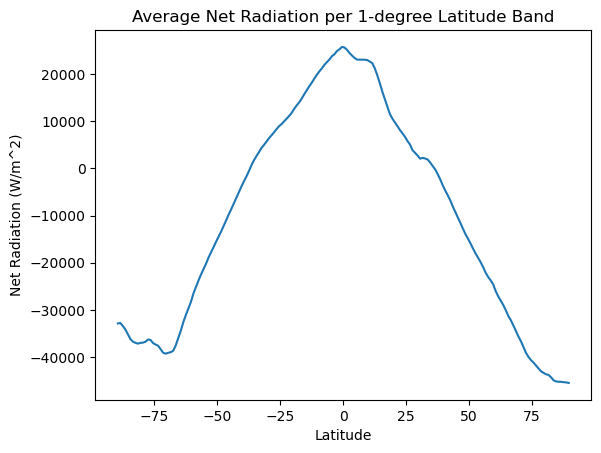

In [16]:
# 选择 'toa_net_all_mon' 变量并按时间求平均
net_radiation = ds['toa_net_all_mon'].mean(dim='time')
# 按纬度聚合数据，计算每个纬度带的净辐射总和
net_radiation_by_lat = net_radiation.sum(dim='lon')
# 绘图
net_radiation_by_lat.plot()

# 设置图表标题和标签
plt.title('Average Net Radiation per 1-degree Latitude Band')
plt.xlabel('Latitude')
plt.ylabel('Net Radiation (W/m^2)')
plt.show()


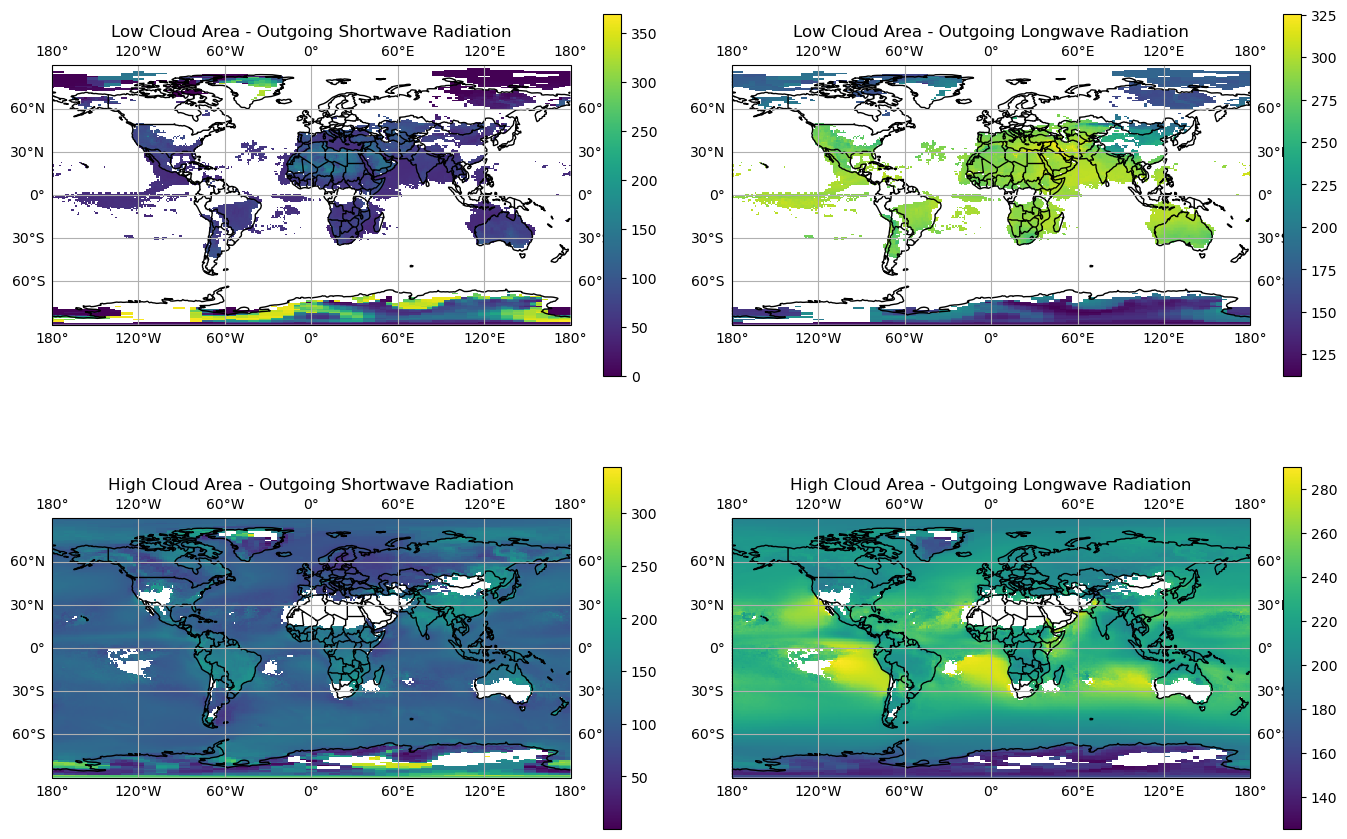

In [19]:
# 定义低云和高云区域
low_cloud = ds['cldarea_total_daynight_mon'] <= 25
high_cloud = ds['cldarea_total_daynight_mon'] >= 75

# 计算时间平均出射辐射
time_mean_sw_low = ds['toa_sw_all_mon'].where(low_cloud).mean(dim='time')
time_mean_lw_low = ds['toa_lw_all_mon'].where(low_cloud).mean(dim='time')
time_mean_sw_high = ds['toa_sw_all_mon'].where(high_cloud).mean(dim='time')
time_mean_lw_high = ds['toa_lw_all_mon'].where(high_cloud).mean(dim='time')

# 绘图设置
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), subplot_kw={'projection': projection})

# 设置色卡
cmap = 'viridis'
# 低云区域的短波辐射地图
img0 = time_mean_sw_low.plot(ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='viridis')
axes[0, 0].set_title('Low Cloud Area - Outgoing Shortwave Radiation')
axes[0, 0].coastlines()
axes[0, 0].add_feature(cfeature.BORDERS)
axes[0, 0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.colorbar(img0, ax=axes[0, 0], orientation='vertical', shrink=0.7)

# 低云区域的长波辐射地图
img1 = time_mean_lw_low.plot(ax=axes[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap)
axes[0, 1].set_title('Low Cloud Area - Outgoing Longwave Radiation')
axes[0, 1].coastlines()
axes[0, 1].add_feature(cfeature.BORDERS)
axes[0, 1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.colorbar(img1, ax=axes[0, 1], orientation='vertical', shrink=0.7)

# 高云区域的短波辐射地图
img2 = time_mean_sw_high.plot(ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap)
axes[1, 0].set_title('High Cloud Area - Outgoing Shortwave Radiation')
axes[1, 0].coastlines()
axes[1, 0].add_feature(cfeature.BORDERS)
axes[1, 0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.colorbar(img2, ax=axes[1, 0], orientation='vertical', shrink=0.7)

# 高云区域的长波辐射地图
img3 = time_mean_lw_high.plot(ax=axes[1, 1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap)
axes[1, 1].set_title('High Cloud Area - Outgoing Longwave Radiation')
axes[1, 1].coastlines()
axes[1, 1].add_feature(cfeature.BORDERS)
axes[1, 1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.colorbar(img3, ax=axes[1, 1], orientation='vertical', shrink=0.7)

plt.tight_layout()
plt.show()

In [20]:
# 选取短波和长波辐射以及云覆盖率变量
shortwave_radiation = ds['toa_sw_all_mon']
longwave_radiation = ds['toa_lw_all_mon']
cloud_area = ds['cldarea_total_daynight_mon']  


# 计算全球平均值
# 高云区域
high_cloud_avg_sw = shortwave_radiation.where(high_cloud).mean(dim=['time', 'lat', 'lon'])
high_cloud_avg_lw = longwave_radiation.where(high_cloud).mean(dim=['time', 'lat', 'lon'])

# 低云区域
low_cloud_avg_sw = shortwave_radiation.where(low_cloud).mean(dim=['time', 'lat', 'lon'])
low_cloud_avg_lw = longwave_radiation.where(low_cloud).mean(dim=['time', 'lat', 'lon'])

# 输出结果
print("High Cloud Area - Shortwave Radiation Global Average:", high_cloud_avg_sw.values)
print("High Cloud Area - Longwave Radiation Global Average:", high_cloud_avg_lw.values)
print("Low Cloud Area - Shortwave Radiation Global Average:", low_cloud_avg_sw.values)
print("Low Cloud Area - Longwave Radiation Global Average:", low_cloud_avg_lw.values)

High Cloud Area - Shortwave Radiation Global Average: 111.76594
High Cloud Area - Longwave Radiation Global Average: 215.39049
Low Cloud Area - Shortwave Radiation Global Average: 97.11116
Low Cloud Area - Longwave Radiation Global Average: 247.33109


### 第二题代码运行正常，可以输出正确结果和图片，报告中也展示了输出内容和结果的分析。第三小问计算total amount总量量级不对，这里面涉及到了计算不同维度下的grid面积，最后辐射强度要跟面积相乘，单位：W。
### 得分：29/30
### --------------------------------------------------------------------------------------------

## 3. Explore a netCDF dataset

In [21]:
filenames = [
    'CMSFluxFossilfuel_2010_v1.nc4',
    'CMSFluxFossilfuel_2011_v1.nc4',
    'CMSFluxFossilfuel_2012_v1.nc4'
]

In [26]:
ds = xr.open_mfdataset(filenames, combine='by_coords')
# 将时间序列重采样为月度平均值
monthly_data = ds['FF'].resample(time='1M').mean()

# 计算每个月的季节性平均值
monthly_climatology = monthly_data.groupby('time.month').mean('time')

# 计算每个月的异常值
monthly_anomaly = monthly_data.groupby('time.month')-monthly_climatology

# 计算异常值的全球平均值并绘制
global_mean_anomaly = monthly_anomaly.mean(dim=['lat', 'lon'])
global_mean_anomaly.plot()

plt.title('Global Mean Qh_tavg Anomalies with Monthly Seasonal Cycle Removed')
plt.xlabel('Time')
plt.ylabel('Qh_tavg Anomalies')
plt.show()

ValueError: unrecognized chunk manager dask - must be one of: []

### 第三题助教代码无法运行可能是版本原因，但学生文件和报告可以输出正确结果和图片，报告中也展示了输出内容和结果
### 得分：10/10
### --------------------------------------------------------------------------------------------